## Sentinel hub worfklow to get band values from input data

First run the tstk-ui localy with python3 main.py to create the necessary shapefiles for data extraction

### Import necessary libraries

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import sentinelhub as sh
from typing import Any, Optional, Tuple
import datetime
import utm

def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: Optional[Tuple[float, float]] = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

### Configuration of SentinelHub

Code to access sentinel hub account

In [131]:
config = sh.SHConfig()
# Id of the client
config.sh_client_id= '5966f3c7-efae-43f2-953e-77c4b2acab64'
# Sectret token for client
config.sh_client_secret = 't&+uvX26@{deQ5{8D._).-uwLi1rX@71|VZGm4zz'

# Check arguments
if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

config.save()

### Bounding box centered in point with 50m apart

In [132]:
# Satelite picture resolution
res = 30
# Distance from center in meters
# 5km to get idea of landscape
global_dist = 5000
# 50m to assume nutrient values
dist = 50
# Location of nutrient extraction
NYC = (40.7687034606934, -73.9791946411133)
DALLAS = (32.3254547119141, -86.8561019897461) #nao há dados
AUTAUGA = (32.4148979187012, -86.4897003173828) #nao há dados
YEMEN = (15.1999998092651, 44.0999984741211) #nao há dados
test = (45.7955513000488, -88.2233734130859)

lat, lon = test

# Converting lat_lon in wgs to utm
east, nort, zone_number, zone_letter = utm.from_latlon(latitude=lat, longitude=lon)
# Keeps bounding boxes
bboxes = []

for d in (global_dist, dist):
    # Calculating bounding box limits
    min_east, max_east, min_nort, max_nort = east-d, east+d, nort-d, nort+d
    # Convert limits to WGS84
    min_lat, min_lon = utm.to_latlon(min_east, min_nort, zone_number, zone_letter)
    max_lat, max_lon = utm.to_latlon(max_east, max_nort, zone_number, zone_letter)

    # Creating UTM type identifier: UTM_<zone><direction>
    crs = sh.constants.CRS
    # Bounding box and its size creation
    bbox = sh.BBox(bbox=(min_lon, min_lat, max_lon, max_lat), crs=sh.constants.CRS.WGS84)
    bbox_size = sh.bbox_to_dimensions(bbox, resolution=res)
    bboxes.append((bbox, bbox_size))

    print(f'Bounding box {d}m around {(lat, lon)} from {(min_lat, min_lon)} to {(max_lat, max_lon)}')
    print(f"Image shape at {res}m resolution: {bbox_size} pixels")

Bounding box 5000m around (45.7955513000488, -88.2233734130859) from (45.74985227311401, -88.28665834232153) to (45.84121590764043, -88.15998500513943)
Image shape at 30m resolution: (333, 333) pixels
Bounding box 50m around (45.7955513000488, -88.2233734130859) from (45.795094481732775, -88.2240067742079) to (45.79600811863709, -88.22274004169971)
Image shape at 30m resolution: (3, 3) pixels


### Calculate time interval

In [133]:
# Calculate the date 5 days prior and after the date of extraction
days = 5

NYC_extraction_date = '1999-07-07'
DALLAS_extraction_date = '1982-08-01'
AUTAUGA_extraction_date = '1982-08-01'
YEMEN_extraction_date = '1982-11-01'
test_extraction_date = '1992-06-13'

extraction_date = test_extraction_date
# Create datetime object from string
extraction_date = datetime.datetime.strptime(extraction_date, '%Y-%m-%d')
# Add and remove 5 days 
start_date = extraction_date - datetime.timedelta(days)
end_date = extraction_date + datetime.timedelta(days)

time_inter = (str(start_date.date()), str(end_date.date()))
print(time_inter)

('1992-06-08', '1992-06-18')


### Satelites to extract

In [134]:
# Both collections are from level 2, as they have higher quality data
# Landsat 4-5 TM
landsat_4_5_l2 = sh.DataCollection.LANDSAT_TM_L2
# Landsat 7 ETM
landsat_7_l2 = sh.DataCollection.LANDSAT_ETM_L2

### Request scripts

In [135]:
# Keeps all request names
request_names = (
    'true_colour',
    'ndmi',
    'ndvi',
    'ndwi',
    'swir'
)

# Request string are made out of the content of ./landsat-4-5-TM/*.js files
true_color_request_str = """
//VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

ndmi_request_str = """
//VERSION=3
const moistureRamps = [
    [-0.8, 0x800000],
    [-0.24, 0xff0000],
    [-0.032, 0xffff00],
    [0.032, 0x00ffff],
    [0.24, 0x0000ff],
    [0.8, 0x000080]
];

const viz = new ColorRampVisualizer(moistureRamps);

function setup() {
    return {
        input: ["B04", "B05", "dataMask"],
        output: [
            { id: "default", bands: 4 },
            { id: "index", bands: 1, sampleType: "FLOAT32" }
        ]
    };
}

function evaluatePixel(samples) {
    let val = index(samples.B04, samples.B05);
    // The library for tiffs works well only if there is only one channel returned.
    // So we encode the "no data" as NaN here and ignore NaNs on frontend.
    const indexVal = samples.dataMask === 1 ? val : NaN;
    return {
        default: [...viz.process(val), samples.dataMask],
        index: [indexVal]
    };
}
"""

ndvi_request_str = """
var val = (B04 - B03) / (B04 + B03);

if (val < -1.1) return [0, 0, 0];
else if (val < -0.2) return [0.75, 0.75, 0.75];
else if (val < -0.1) return [0.86, 0.86, 0.86];
else if (val < 0) return [1, 1, 0.88];
else if (val < 0.025) return [1, 0.98, 0.8];
else if (val < 0.05) return [0.93, 0.91, 0.71];
else if (val < 0.075) return [0.87, 0.85, 0.61];
else if (val < 0.1) return [0.8, 0.78, 0.51];
else if (val < 0.125) return [0.74, 0.72, 0.42];
else if (val < 0.15) return [0.69, 0.76, 0.38];
else if (val < 0.175) return [0.64, 0.8, 0.35];
else if (val < 0.2) return [0.57, 0.75, 0.32];
else if (val < 0.25) return [0.5, 0.7, 0.28];
else if (val < 0.3) return [0.44, 0.64, 0.25];
else if (val < 0.35) return [0.38, 0.59, 0.21];
else if (val < 0.4) return [0.31, 0.54, 0.18];
else if (val < 0.45) return [0.25, 0.49, 0.14];
else if (val < 0.5) return [0.19, 0.43, 0.11];
else if (val < 0.55) return [0.13, 0.38, 0.07];
else if (val < 0.6) return [0.06, 0.33, 0.04];
else return [0, 0.27, 0];
"""

ndwi_request_str = """
//VERSION=3
//ndwi
const colorRamp1 = [
    [0, 0xFFFFFF],
    [1, 0x008000]
];
const colorRamp2 = [
    [0, 0xFFFFFF],
    [1, 0x0000CC]
];

let viz1 = new ColorRampVisualizer(colorRamp1);
let viz2 = new ColorRampVisualizer(colorRamp2);

function setup() {
    return {
        input: ["B03", "B05", "dataMask"],
        output: [
            { id: "default", bands: 4 },
            { id: "index", bands: 1, sampleType: "FLOAT32" }
        ]
    };
}

function evaluatePixel(samples) {
    let val = index(samples.B03, samples.B05);
    let imgVals = null;
    // The library for tiffs works well only if there is only one channel returned.
    // So we encode the "no data" as NaN here and ignore NaNs on frontend.
    const indexVal = samples.dataMask === 1 ? val : NaN;

    if (val < -0) {
        imgVals = [...viz1.process(-val), samples.dataMask];
    } else {
        imgVals = [...viz2.process(Math.sqrt(Math.sqrt(val))), samples.dataMask];
    }
    return {
        default: imgVals,
        index: [indexVal]
    };
}
"""

swir_request_str = """
  //VERSION=3
let minVal = 0.0;
let maxVal = 0.4;

let viz = new HighlightCompressVisualizer(minVal, maxVal);

function setup() {
  return {
    input: ["B07", "B05", "B03","dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(samples) {
    let val = [samples.B07, samples.B05, samples.B03,samples.dataMask];
    return viz.processList(val);
}
"""

### Create the data request

In [136]:
# Collection of all requests
request_strs = (true_color_request_str, ndmi_request_str, ndvi_request_str,
                ndwi_request_str, swir_request_str)

requests = []

# Create request object for all requests
# We just want the true_color request to have 5km, the rest only 50m
for request in request_strs:
    # Build request object with request string
    if request == true_color_request_str:
        bbox, bbox_size = bboxes[0]
    else:
        bbox, bbox_size = bboxes[1]

    requests.append(sh.SentinelHubRequest(
        evalscript=request,
        input_data=[
            sh.SentinelHubRequest.input_data(
                data_collection=landsat_4_5_l2,
                time_interval=time_inter,
                maxcc=0.1
            )
        ],
        responses=[sh.SentinelHubRequest.output_response("default", sh.MimeType.PNG)],
        bbox=bbox,
        size=bbox_size,
        config=config,
    ))

In [137]:
# Keeps all the data
data_values = []

# Execute all requests in requests
for request in requests:
    data = request.get_data()
    # Get the numpy array of data
    print(f"Returned data is of type = {type(data)} and length {len(data)}.")
    print(f"Single element in the list is of type {type(data[-1])} and has shape {data[-1].shape}")
    data_values.append(data)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (333, 333, 3)
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (3, 3, 4)
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (3, 3, 3)
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (3, 3, 4)
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (3, 3, 4)


### Plot the created image

Image true_colour with shape (333, 333, 3)
Image ndmi with shape (3, 3, 4)
Image ndvi with shape (3, 3, 3)
Image ndwi with shape (3, 3, 4)
Image swir with shape (3, 3, 4)


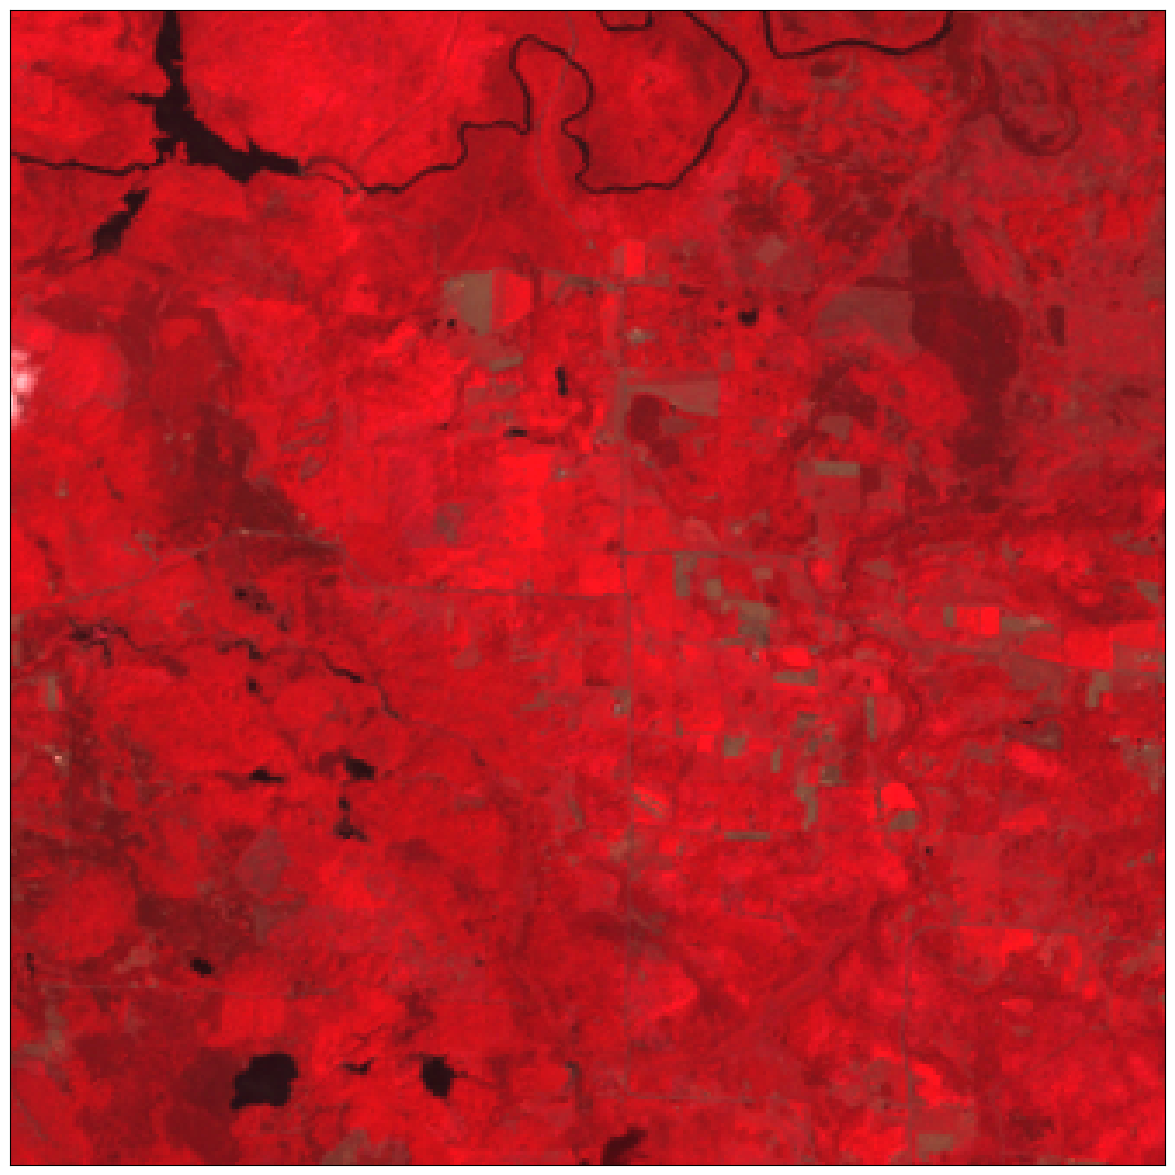

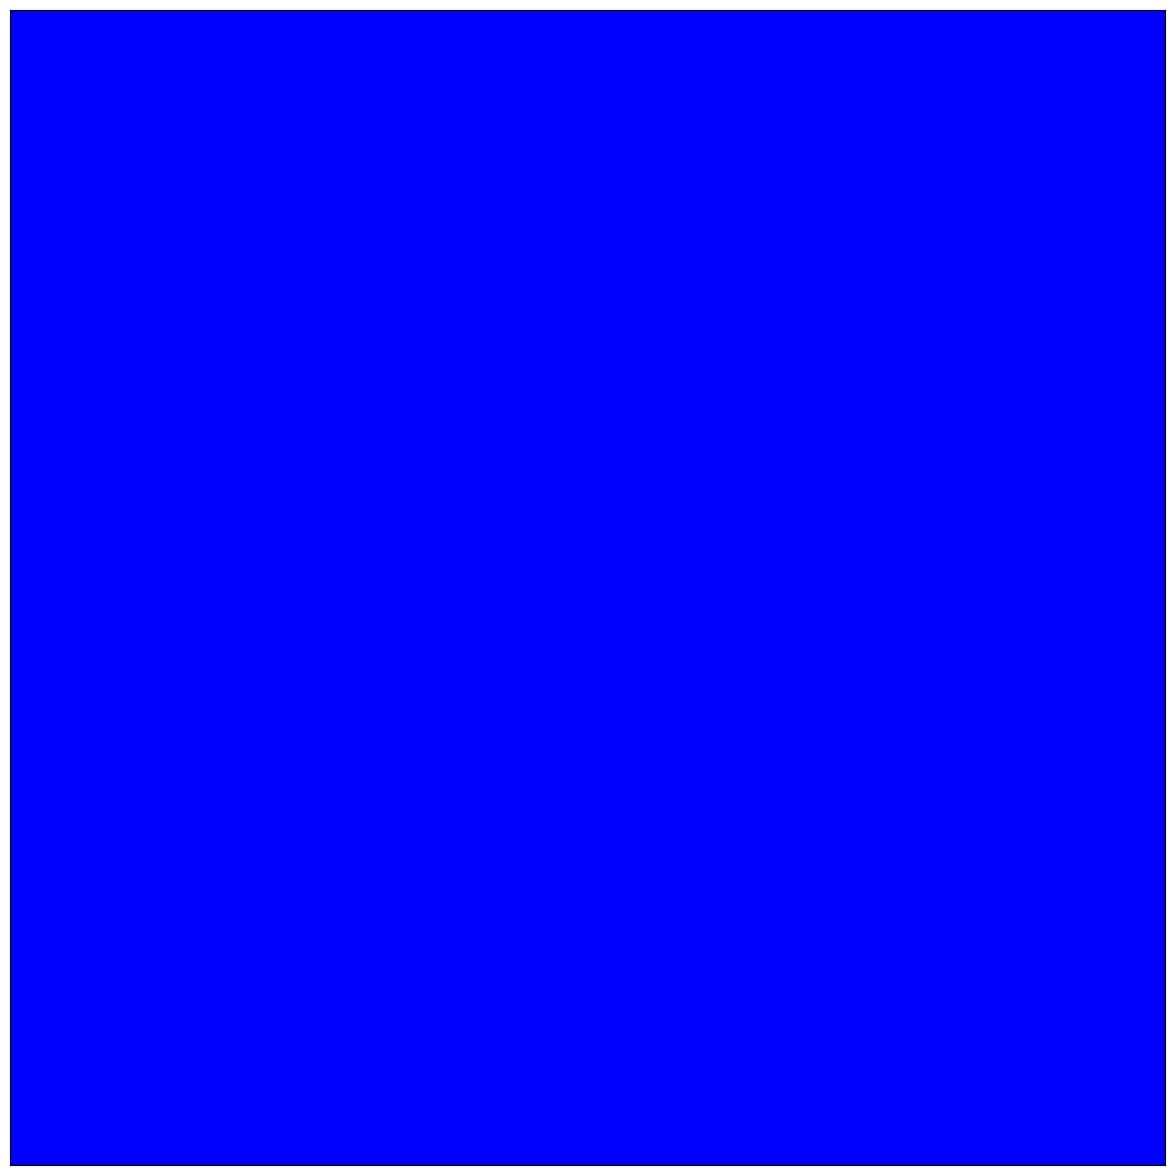

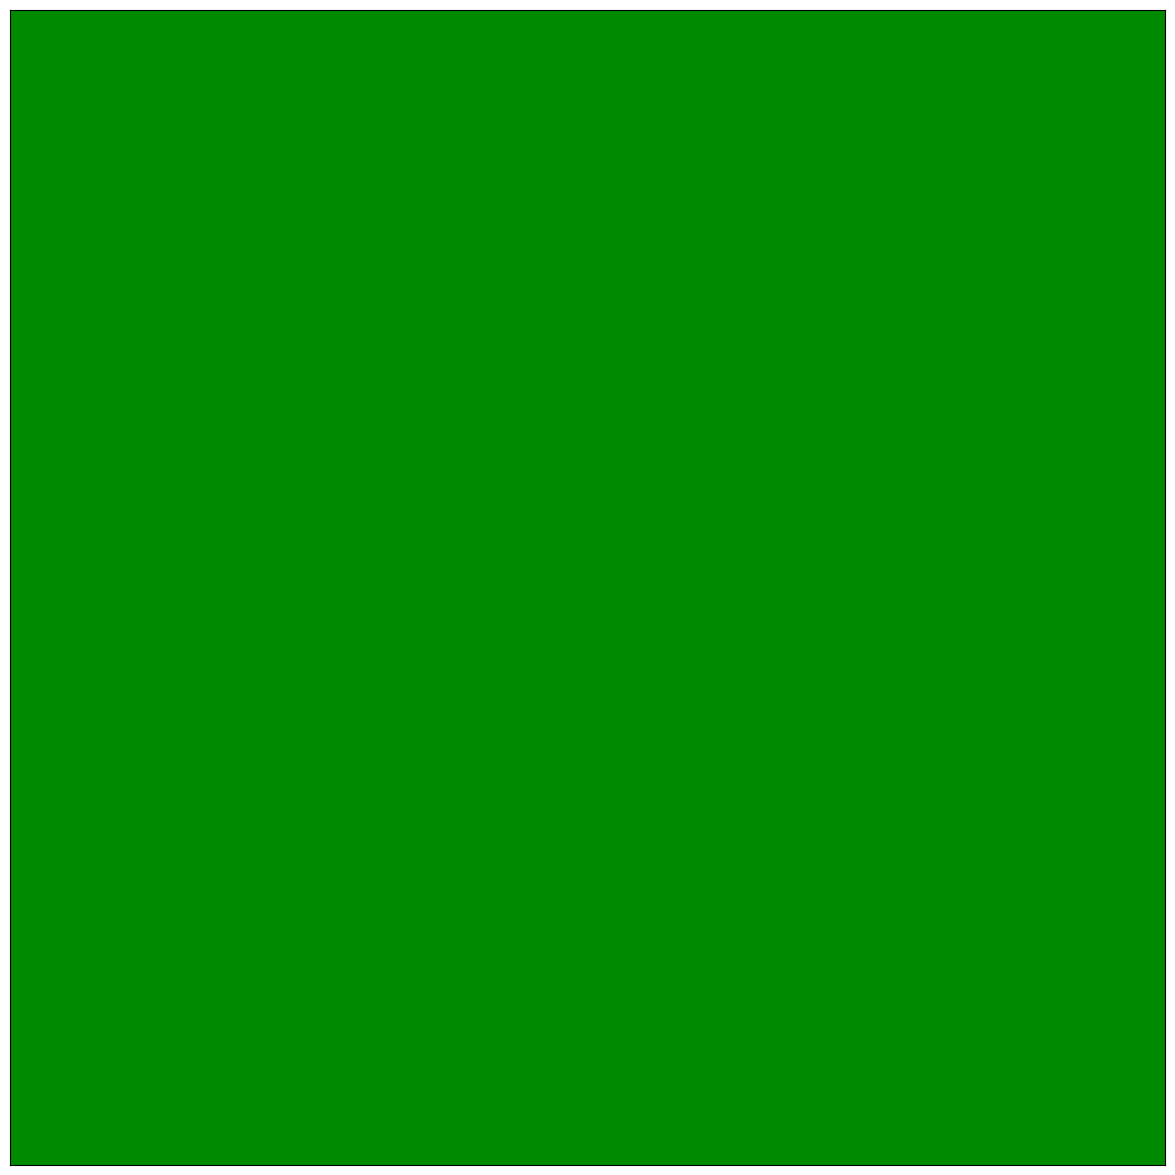

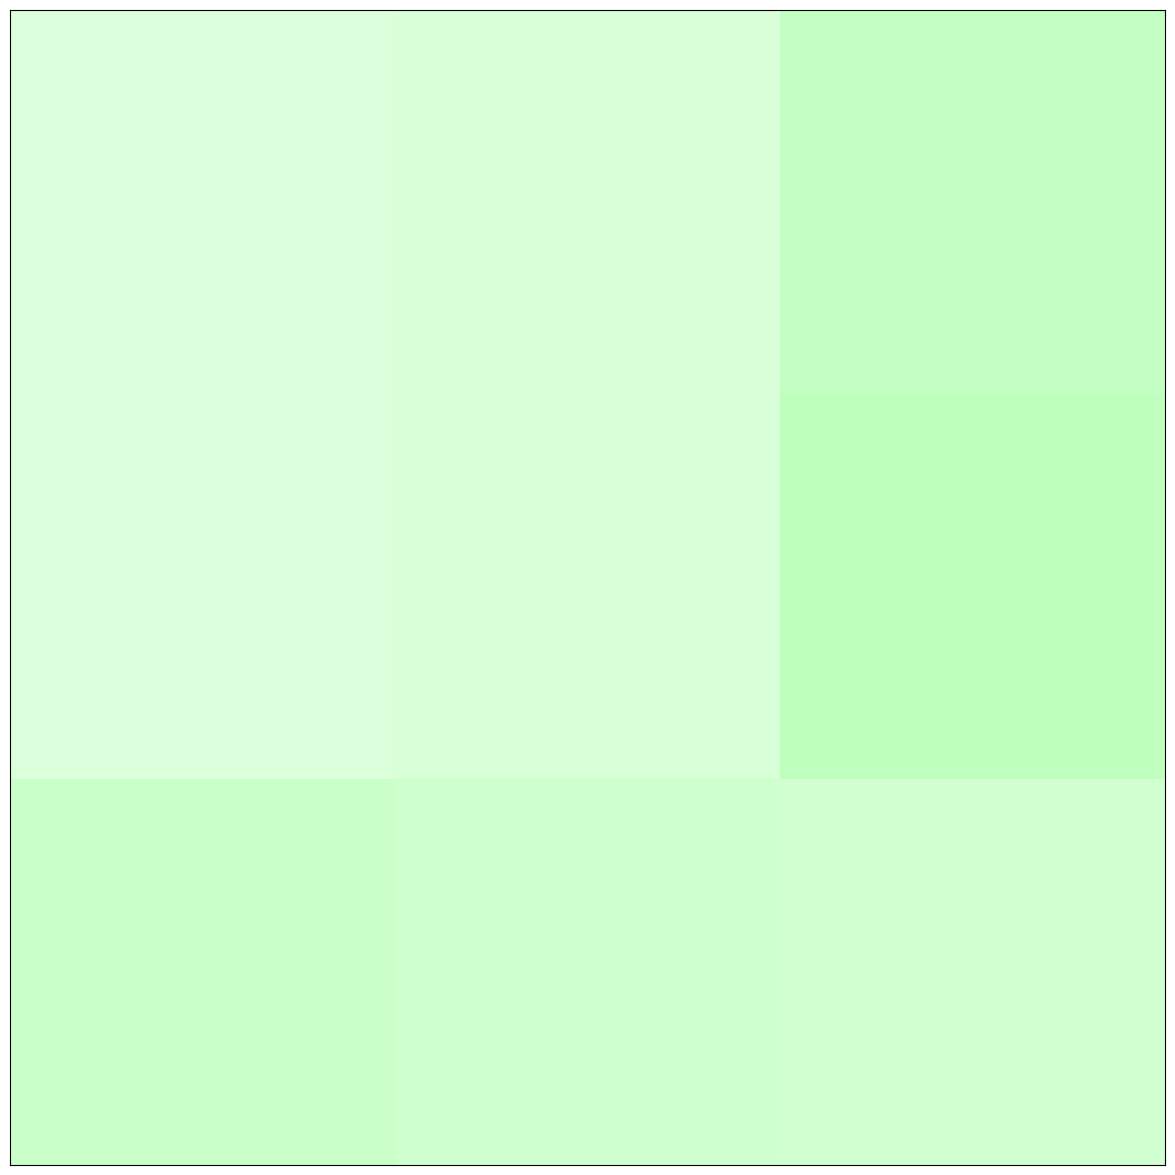

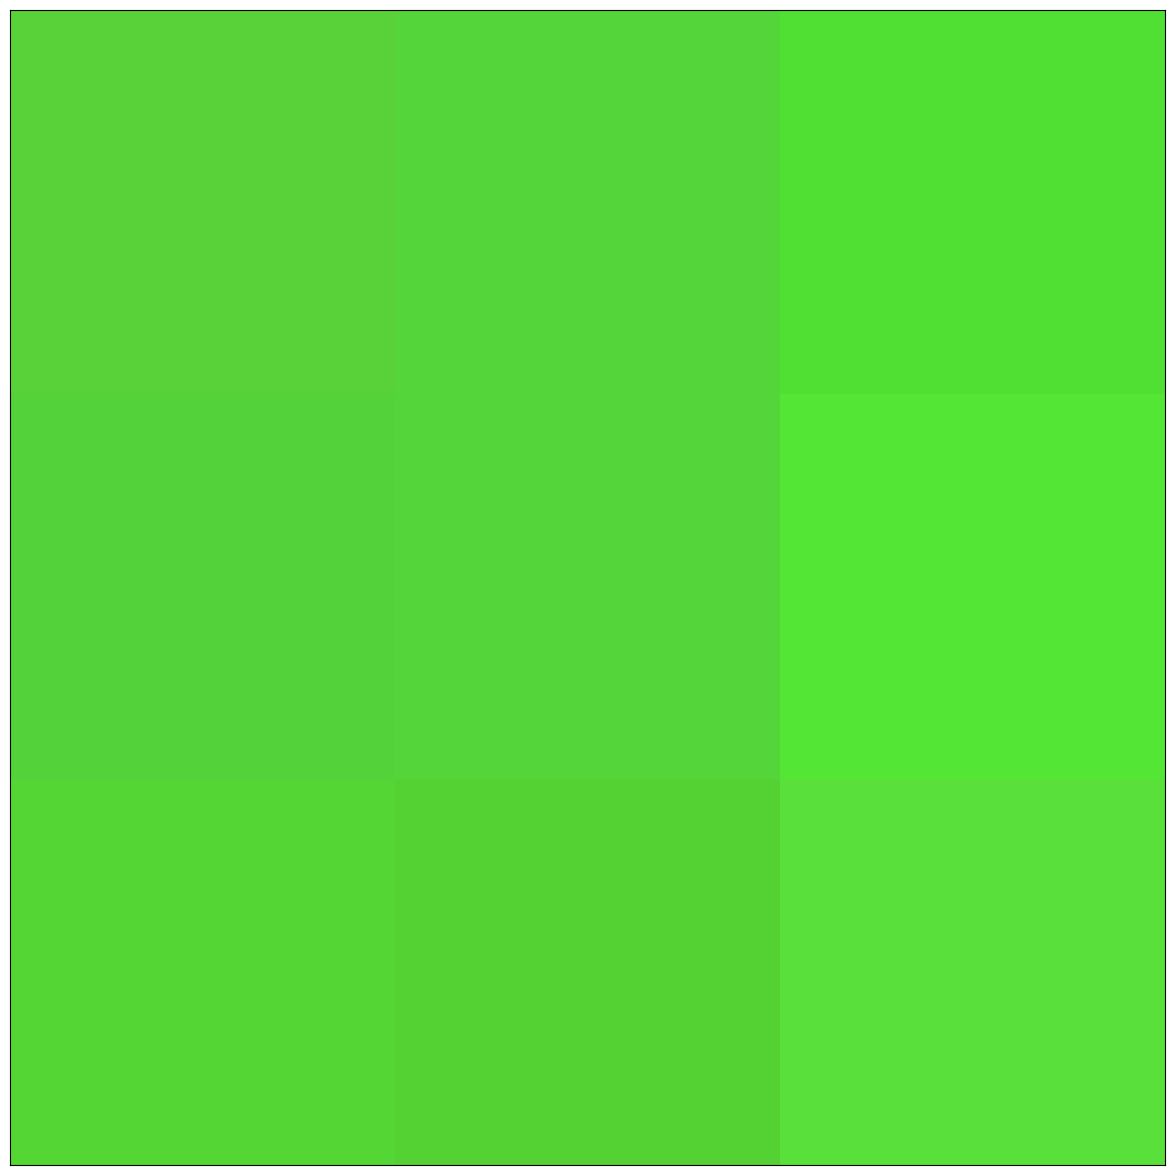

In [138]:
for data, request_name in zip(data_values, request_names):
    image = data[0]
    print(f"Image {request_name} with shape {image.shape}")

    # factor 1/255 to scale between 0-1
    # factor 2 to increase brightness
    print(image)
    plot_image(image, factor=2 / 255, clip_range=(0, 1))